## Prepare inputs (sequences and attribution maps)

In [11]:
import numpy as np
from pathlib import Path

In [12]:
BASE_DIR = Path.cwd().parent
print(f"Base directory: {BASE_DIR}")

DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results"

onehot_path = DATA_DIR / "onehot.npz"
attr_path = DATA_DIR / "attributions.npz"
y_path = DATA_DIR / "log1p_y_counts.npz"
meme_db_path = DATA_DIR / "JASPAR2026_CORE_vertebrates_non-redundant_pfms_meme.txt"

tfmodisco_output_h5 = RESULTS_DIR / "tfmodisco_results.h5"
tfmodisco_output_dir = RESULTS_DIR / "tfmodisco_report"
# tfmodisco_meme_path = RESULTS_DIR / "tfmodisco_motifs.meme"

Base directory: /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis


In [13]:
X = np.load(onehot_path)['arr_0']
X_attr = np.load(attr_path)['arr_0']
y = np.load(y_path)['arr_0']
print(f"X shape: {X.shape}")
print(f"X_attr shape: {X_attr.shape}")
print(f"y shape: {y.shape}")

X shape: (3699, 4, 2114)
X_attr shape: (3699, 4, 2114)
y shape: (3699,)


## Motif discovery via TF-MoDISCo-lite

In [ ]:
import subprocess

def run_tfmodisco(
    seq_path,
    attr_path,
    output_h5="tfmodisco_results.h5",
    output_dir="tfmodisco_report",
    n_seqlets=2000,
    window_size=1000,
    meme_db=None,
):
    """Run tfmodisco-lite for motif discovery"""

    # Run modisco motifs
    cmd_motifs = [
        "modisco",
        "motifs",
        "-s",
        str(seq_path),
        "-a",
        str(attr_path),
        "-n",
        str(n_seqlets),
        "-o",
        str(output_h5),
        "-w",
        str(window_size),
    ]
    print("CMD:", " ".join(cmd_motifs))
    subprocess.run(cmd_motifs, check=True)

    # Generate report
    cmd_report = ["modisco", "report", "-i", str(output_h5), "-o", str(output_dir)]
    if meme_db is not None:
        cmd_report += ["-m", str(meme_db)]
    print("CMD:", " ".join(cmd_report))
    subprocess.run(cmd_report, check=True)

    print(f"TF-MoDISco results saved to {output_h5}")
    print(f"Report saved to {output_dir}")

In [10]:
run_tfmodisco(
    seq_path=onehot_path,
    attr_path=attr_path,
    output_h5=tfmodisco_output_h5,
    output_dir=tfmodisco_output_dir,
    meme_db=meme_db_path,
    n_seqlets=2000,
    window_size=1000
)

CMD: modisco motifs -s /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis/data/onehot.npz -a /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis/data/attributions.npz -n 2000 -o /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis/results/tfmodisco_results.h5 -w 1000
CMD: modisco report -i /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis/results/tfmodisco_results.h5 -o /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis/results/tfmodisco_report -m /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis/data/JASPAR2026_CORE_vertebrates_non-redundant_pfms_meme.txt
TF-MoDISco results saved to /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis/results/tfmodisco_results.h5
Report saved to /grid/koo/home/nagai/projects/continual_learning/clg_procap/motif_analysis/results/tfmodisco_report


## Get motifs from TF-MoDISco results

In [15]:
def get_motifs_from_tfmodisco(modisco_h5_path, use_cwm=False, trim_threshold=0.0):
    """
    Extract motifs from a TF-MoDISco HDF5 file as numpy arrays.

    Motifs are returned as an OrderedDict mapping motif names to numpy arrays.
    The array represents:
      - PFM (position frequency matrix) if use_cwm=False
      - CWM (contribution weight matrix) if use_cwm=True

    Motifs are sorted first by metacluster (pos_patterns, then neg_patterns),
    and then by numeric pattern index within each metacluster.

    Flanking positions can optionally be trimmed using TF-MoDISco-lite semantics:
    positions are kept if the maximum base probability at that position is >= trim_threshold.

    Parameters
    ----------
    modisco_h5_path : str or Path
        Path to the TF-MoDISco output HDF5 file.
    use_cwm : bool, default False
        If True, return CWMs (contrib_scores).
        If False, return PFMs (sequence).
    trim_threshold : float, default 0.0
        If provided, trim flanks until a position has at least one base
        with probability >= trim_threshold.

    Returns
    -------
    OrderedDict[str, np.ndarray]
        Mapping from motif name to PFM or CWM numpy array.
    """
    import re
    import h5py
    import numpy as np
    from collections import OrderedDict

    def extract_pattern_number(pattern_name):
        match = re.search(r'pattern_(\d+)', pattern_name)
        return int(match.group(1)) if match else 0

    def trim_motif(matrix, threshold):
        """Trim flanking positions using max-probability criterion"""
        prob_matrix = np.abs(matrix) + 1e-6
        prob_matrix = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)

        max_probs = prob_matrix.max(axis=1)
        keep = max_probs >= threshold

        if not keep.any():
            return matrix

        indices = np.where(keep)[0]
        start, end = indices[0], indices[-1] + 1
        return matrix[start:end]

    with h5py.File(modisco_h5_path, 'r') as f:
        all_motifs = []

        for metacluster in ['pos_patterns', 'neg_patterns']:
            if metacluster not in f:
                continue

            for pattern_name in f[metacluster].keys():
                pattern = f[metacluster][pattern_name]
                motif_name = f"{metacluster}_{pattern_name}"

                value = None
                if use_cwm and 'contrib_scores' in pattern:
                    value = pattern['contrib_scores'][:]
                elif not use_cwm and 'sequence' in pattern:
                    value = pattern['sequence'][:]

                if value is not None and trim_threshold is not None:
                    value = trim_motif(value, trim_threshold)

                all_motifs.append({
                    'name': motif_name,
                    'metacluster': metacluster,
                    'pattern_num': extract_pattern_number(pattern_name),
                    'value': value,
                })

        all_motifs.sort(key=lambda x: (
            0 if x['metacluster'] == 'pos_patterns' else 1,
            x['pattern_num']
        ))

        motif_data = OrderedDict(
            (motif['name'], motif['value'].transpose(1, 0)) for motif in all_motifs
        )

    return motif_data


In [16]:
motif_dict = get_motifs_from_tfmodisco(tfmodisco_output_h5, trim_threshold=0.4)
print(f"Extracted {len(motif_dict)} motifs from TF-MoDISco results.")
for motif_name, motif_matrix in motif_dict.items():
    print(f"{motif_name}: {motif_matrix.shape}")

Extracted 12 motifs from TF-MoDISco results.
pos_patterns_pattern_0: (4, 9)
pos_patterns_pattern_1: (4, 35)
pos_patterns_pattern_2: (4, 40)
pos_patterns_pattern_3: (4, 44)
pos_patterns_pattern_4: (4, 38)
pos_patterns_pattern_5: (4, 49)
pos_patterns_pattern_6: (4, 46)
pos_patterns_pattern_7: (4, 45)
pos_patterns_pattern_8: (4, 48)
pos_patterns_pattern_9: (4, 50)
pos_patterns_pattern_10: (4, 43)
pos_patterns_pattern_11: (4, 48)


### Visualize the motifs

In [8]:
def stack_and_pad_motifs(motifs):
    N = len(motifs)
    Lmax = max(m.shape[1] for m in motifs)

    stacked = np.zeros((N, 4, Lmax), dtype=motifs[0].dtype)

    for i, motif in enumerate(motifs):
        Li = motif.shape[1]
        pad_left = (Lmax - Li) // 2
        # pad_right = Lmax - Li - pad_left
        stacked[i, :, pad_left:pad_left + Li] = motif

    return stacked

In [9]:
motifs_padded = stack_and_pad_motifs(list(motif_dict.values()))
print(f"Padded motifs shape: {motifs_padded.shape}")

Padded motifs shape: (12, 4, 50)


Processing logos: 100%|██████████| 12/12 [00:00<00:00, 168.30it/s]


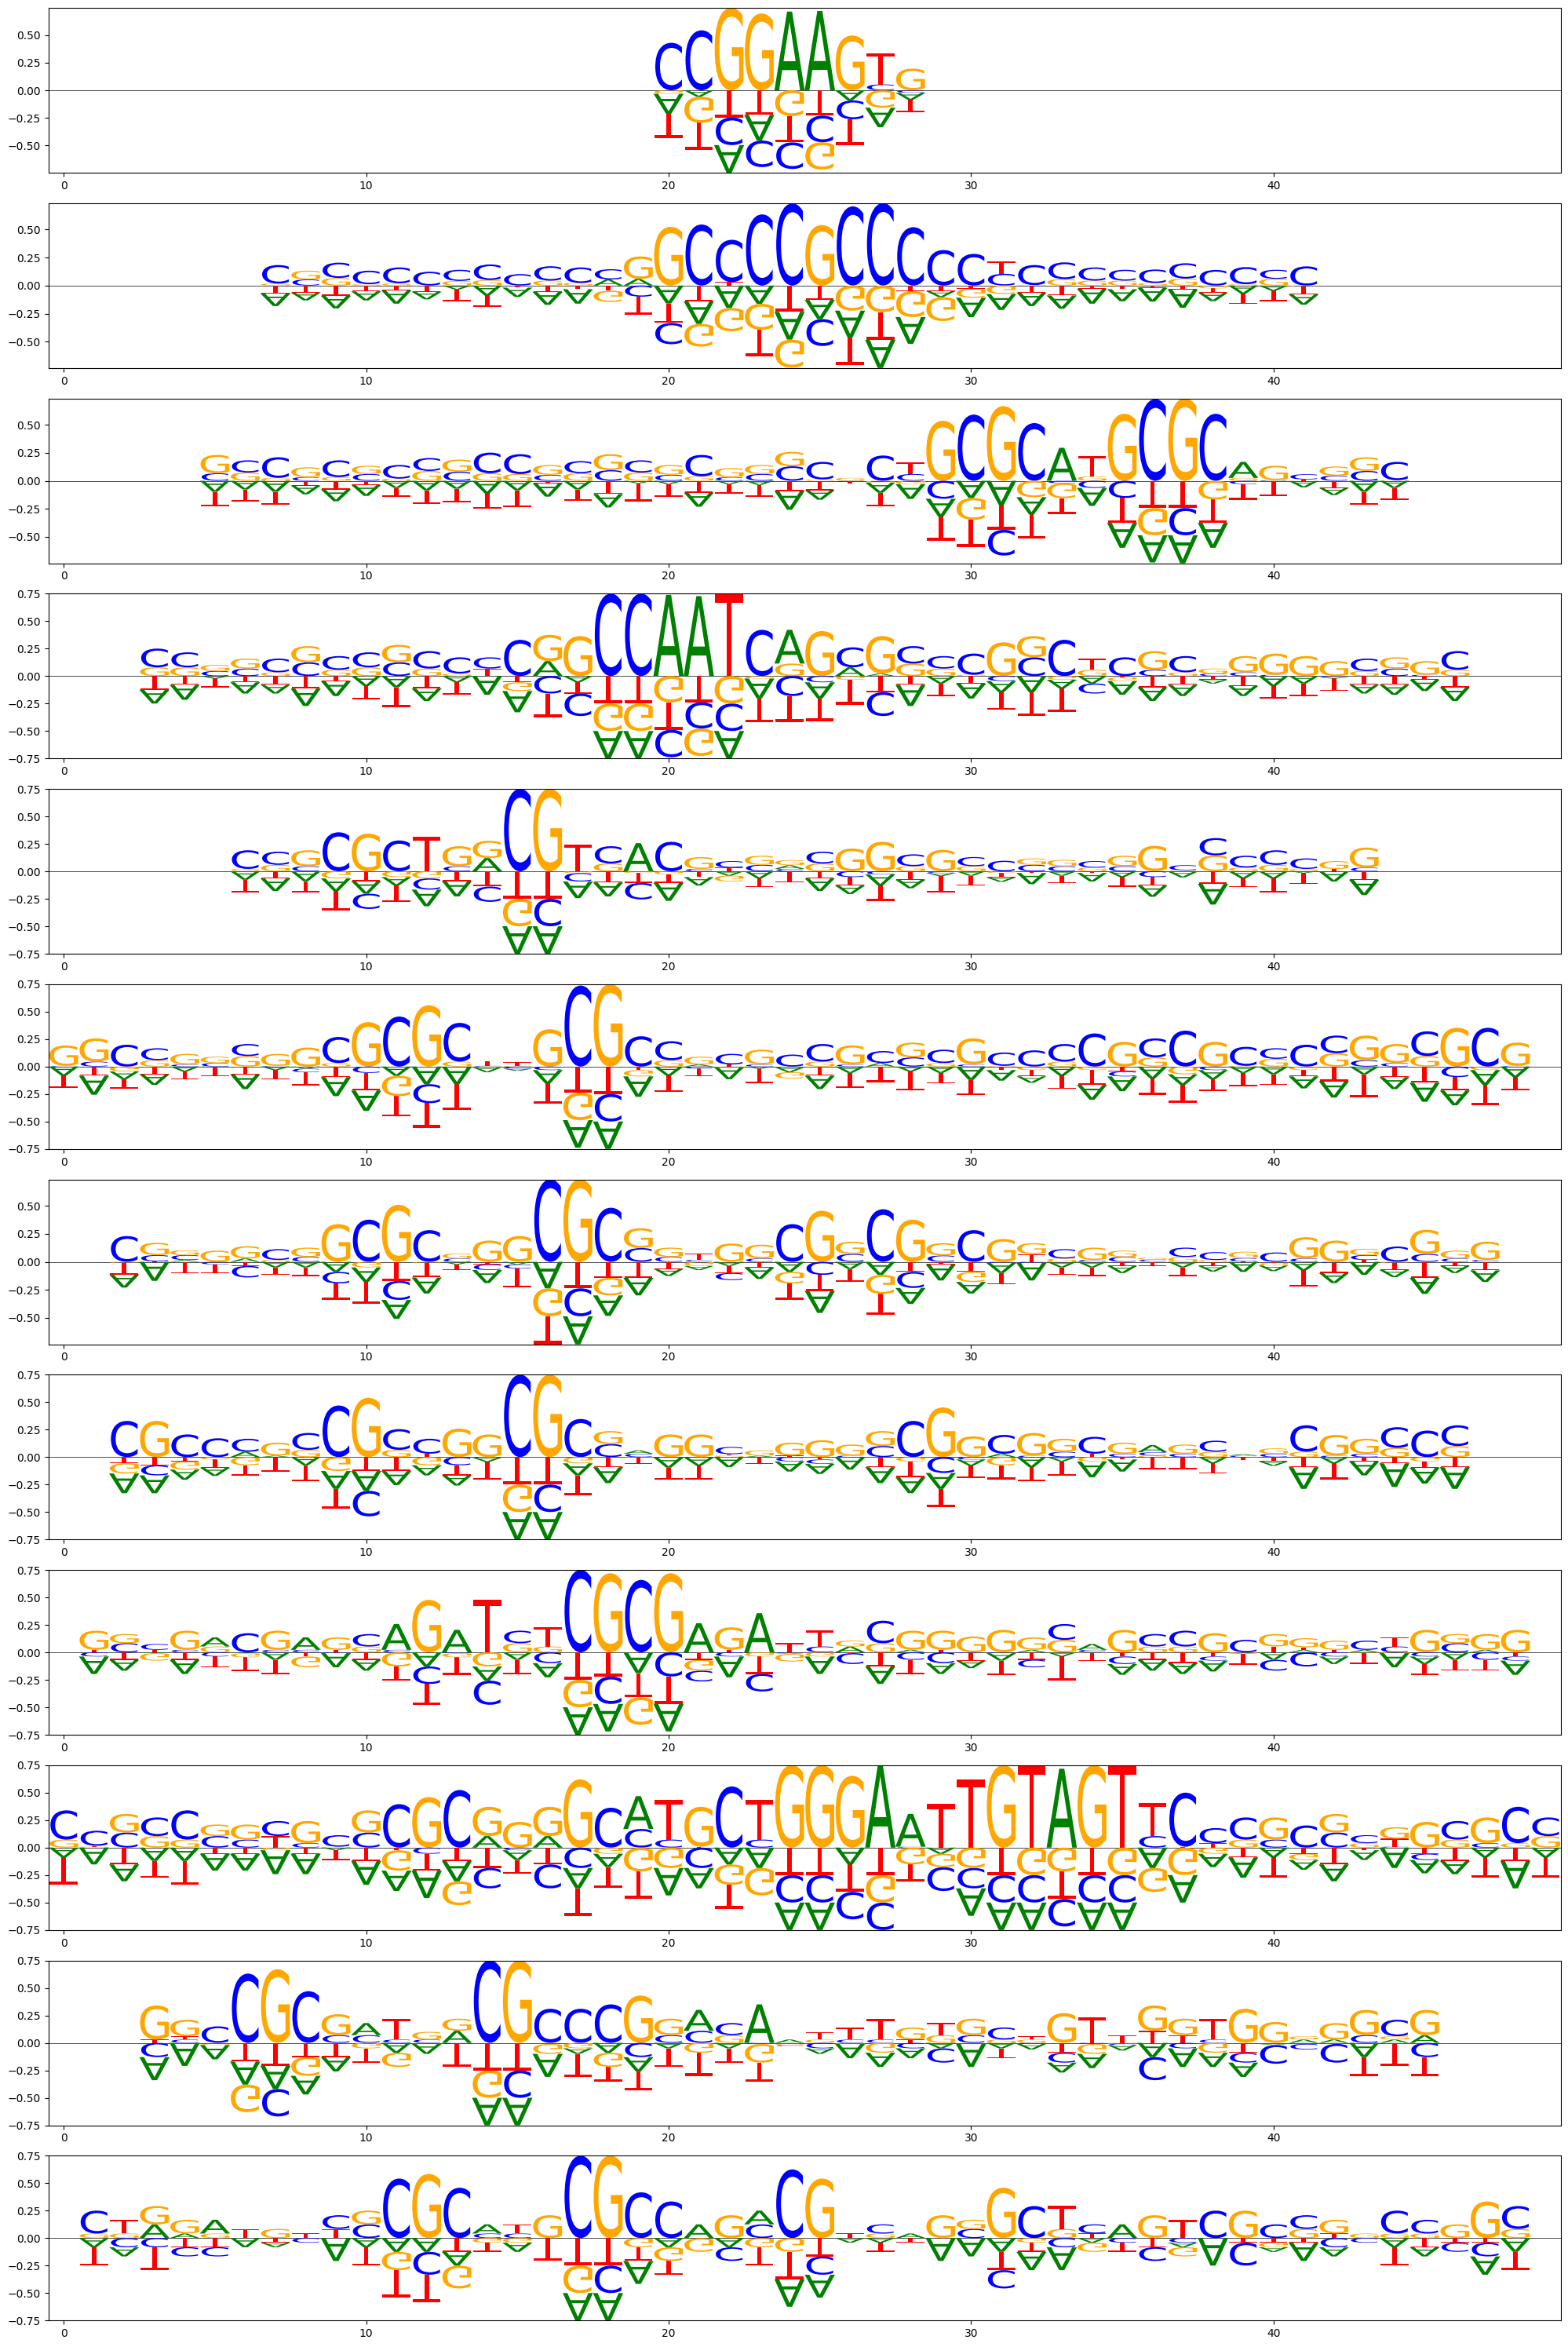

In [10]:
import matplotlib.pyplot as plt
from logomaker_batch import BatchLogo

batch_logo = BatchLogo(
    motifs_padded.transpose(0, 2, 1),
    alphabet=['A', 'C', 'G', 'T'],
    fig_size=[20, 2.5],
    center_values=True,
    batch_size=1,
    # y_min_max=[y_min, y_max],
)

batch_logo.process_all()

fig, axes = batch_logo.draw_logos(
    indices=None,
    rows=len(motifs_padded),
    cols=1)

plt.show()

## Scan sequences with FIMO

In [11]:
from memelite.fimo import fimo

hits = fimo(
    motifs=motif_dict,
    sequences=X,
)

In [12]:
hits[1]

,motif_name,motif_idx,sequence_name,start,end,strand,score,p-value
0,pos_patterns_pattern_1,1,0,893,928,+,10.345183,0.000071
1,pos_patterns_pattern_1,1,0,1005,1040,+,12.606018,0.000019
2,pos_patterns_pattern_1,1,0,1071,1106,+,11.386159,0.000041
3,pos_patterns_pattern_1,1,0,1077,1112,+,14.291073,0.000007
4,pos_patterns_pattern_1,1,0,1136,1171,+,12.002744,0.000027
...,...,...,...,...,...,...,...,...
72125,pos_patterns_pattern_1,1,3698,888,923,-,9.774062,0.000098
72126,pos_patterns_pattern_1,1,3698,1045,1080,-,16.201104,0.000001
72127,pos_patterns_pattern_1,1,3698,1050,1085,-,12.867538,0.000016
72128,pos_patterns_pattern_1,1,3698,1056,1091,-,16.319794,0.000001


## Build sequence ×  motif matrix

In [13]:
def build_motif_matrix(fimo_df_list, n_sequences, attributions=None, aggregate='sum'):
    """
    Build sequence x motif matrix from memelite FIMO results.

    Parameters
    ----------
    fimo_df_list : list of pandas.DataFrame
        List of DataFrames from memelite FIMO (one per motif).
    n_sequences : int
        Total number of sequences.
    attributions : array_like, optional
        Attribution array with shape (N, 4, L) for weighting hits. Default is None.
    aggregate : {'max', 'sum', 'count', 'binary'}, optional
        Aggregation method for multiple hits. Default is 'max'.

    Returns
    -------
    motif_matrix : numpy.ndarray
        Array of shape (n_sequences, n_motifs) containing aggregated motif scores.
    """
    n_motifs = len(fimo_df_list)
    motif_matrix = np.zeros((n_sequences, n_motifs))

    def reverse_complement_attribution(attr_region):
        return attr_region[::-1, ::-1]

    # Process each motif's hits
    for motif_idx, fimo_df in enumerate(fimo_df_list):
        if len(fimo_df) == 0:
            continue

        # Group by sequence for efficiency
        for seq_idx in range(n_sequences):
            # Filter hits for this sequence
            seq_hits = fimo_df[fimo_df['sequence_name'] == seq_idx]

            if len(seq_hits) == 0:
                continue

            # Get scores (potentially weighted by attribution)
            scores = seq_hits['score'].values

            if attributions is not None:
                # Weight each hit by its attribution
                attr_weights = []
                for _, row in seq_hits.iterrows():
                    start, end = row['start'], row['end']
                    strand = row['strand']

                    # Extract attribution region
                    attr_region = attributions[seq_idx, :, start:end]

                    # If hit is on negative strand, reverse complement the attribution
                    if strand == '-':
                        attr_region = reverse_complement_attribution(attr_region)

                    # Calculate mean absolute attribution
                    # attr_weight = np.abs(attr_region).mean()
                    attr_weight = np.abs(attr_region).sum(axis=0).mean()  # sum over nucleotides, then mean over positions
                    attr_weights.append(attr_weight)

                attr_weights = np.array(attr_weights)
                scores = scores * attr_weights

            # Aggregate
            if aggregate == 'max':
                motif_matrix[seq_idx, motif_idx] = scores.max()
            elif aggregate == 'sum':
                motif_matrix[seq_idx, motif_idx] = scores.sum()
            elif aggregate == 'count':
                motif_matrix[seq_idx, motif_idx] = len(scores)
            elif aggregate == 'binary':
                motif_matrix[seq_idx, motif_idx] = 1.0

    return motif_matrix

In [14]:
motif_matrix = build_motif_matrix(
    fimo_df_list=hits,
    n_sequences=X.shape[0],
    attributions=X_attr,
    aggregate='sum'
)

In [15]:
motif_matrix.shape

(3699, 12)

## Visualize the matrix

In [16]:
# ============================================================================
# PCA Visualization
# ============================================================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_pca(motif_matrix, labels=None, motif_names=None,
             n_components=2, figsize=(15, 5)):
    """
    PCA visualization of motif matrix

    Args:
        motif_matrix: (N, n_motifs) array
        labels: Optional (N,) array of labels for coloring points
        motif_names: Optional list of motif names for loading plot
        n_components: Number of PCA components to compute
        figsize: Figure size

    Returns:
        pca: Fitted PCA object
        coords: (N, n_components) PCA coordinates
    """
    # Standardize features (motifs)
    scaler = StandardScaler()
    motif_matrix_scaled = scaler.fit_transform(motif_matrix)

    # Fit PCA
    pca = PCA(n_components=n_components)
    coords = pca.fit_transform(motif_matrix_scaled)

    # Create figure
    if motif_names is not None:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes = [axes[0], axes[1], None]

    # Plot 1: PCA scatter
    if labels is not None:
        scatter = axes[0].scatter(coords[:, 0], coords[:, 1],
                                 c=labels, alpha=0.6, cmap='viridis', s=3)
        plt.colorbar(scatter, ax=axes[0], label='Label')
    else:
        axes[0].scatter(coords[:, 0], coords[:, 1], alpha=0.6, s=3)

    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[0].set_title('PCA of Motif Matrix')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Variance explained
    var_exp = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)

    axes[1].bar(range(1, len(var_exp) + 1), var_exp, alpha=0.6, label='Individual')
    axes[1].plot(range(1, len(var_exp) + 1), cum_var_exp, 'ro-', label='Cumulative')
    axes[1].set_xlabel('Principal Component')
    axes[1].set_ylabel('Variance Explained')
    axes[1].set_title('Variance Explained by PCs')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Loading plot (if motif names provided)
    if motif_names is not None and axes[2] is not None:
        loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

        # Plot top contributors
        top_n = min(15, len(motif_names))
        loading_magnitude = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)
        top_indices = np.argsort(loading_magnitude)[-top_n:]

        for idx in top_indices:
            axes[2].arrow(0, 0, loadings[idx, 0], loadings[idx, 1],
                         head_width=0.05, head_length=0.05,
                         fc='red', ec='red', alpha=0.6)
            axes[2].text(loadings[idx, 0]*1.15, loadings[idx, 1]*1.15,
                        motif_names[idx], fontsize=8, ha='center')

        axes[2].set_xlabel(f'PC1 Loading')
        axes[2].set_ylabel(f'PC2 Loading')
        axes[2].set_title('Top Motif Loadings')
        axes[2].grid(True, alpha=0.3)
        axes[2].axhline(y=0, color='k', linestyle='--', linewidth=0.5)
        axes[2].axvline(x=0, color='k', linestyle='--', linewidth=0.5)

    plt.tight_layout()

    # Print summary
    print(f"PCA Summary:")
    print(f"  Total variance explained by PC1-PC2: {cum_var_exp[1]:.1%}")
    print(f"  Input shape: {motif_matrix.shape}")
    print(f"  Output shape: {coords.shape}")

    return pca, coords, fig

PCA Summary:
  Total variance explained by PC1-PC2: 71.4%
  Input shape: (3699, 12)
  Output shape: (3699, 12)


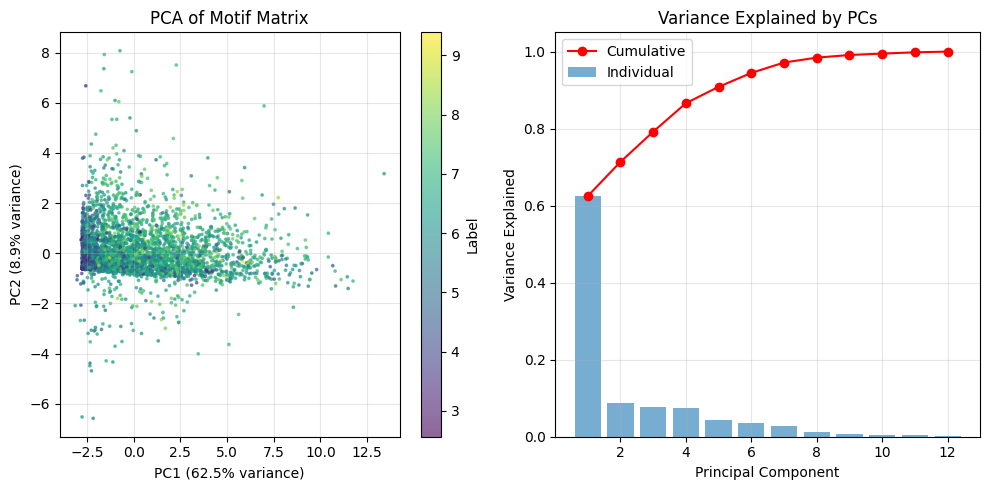

In [17]:
n_components = 12

pca, pca_coords, pca_fig = plot_pca(
    motif_matrix=motif_matrix,
    labels=y,
    n_components=n_components,
    figsize=(15, 5)
)

In [18]:
import pandas as pd

pd.DataFrame(pca.components_, index=[f"PC{x+1}" for x in range(n_components)])

,0,1,2,3,4,5,6,7,8,9,10,11
PC1,-0.003702,0.294379,0.352750,0.110207,0.350209,0.358198,0.354717,0.353701,0.279238,-0.086398,0.278932,0.334106
PC2,0.793651,-0.029376,-0.050327,0.192308,-0.040605,-0.040663,-0.048985,-0.038633,0.060601,-0.562531,0.041205,-0.027077
PC3,-0.497217,0.055709,-0.053960,0.707777,-0.044544,-0.019690,-0.028217,-0.016810,-0.103592,-0.465435,-0.106587,-0.060328
PC4,0.301030,-0.081464,-0.014787,0.669924,-0.021815,-0.016695,-0.007241,-0.011188,0.035107,0.669363,0.049764,0.032249
PC5,-0.169576,-0.557496,-0.001602,0.013045,-0.115341,-0.101596,-0.042476,-0.136234,0.401642,-0.084031,0.669178,-0.010225
PC6,-0.042331,0.036524,-0.086251,0.004991,0.011628,-0.017090,-0.035500,-0.034857,0.845840,0.015459,-0.498556,-0.149218
PC7,-0.013177,0.732025,-0.195633,-0.004640,-0.133858,-0.079378,-0.110986,-0.189440,0.134049,0.061823,0.447168,-0.362626
PC8,-0.033877,0.220714,-0.033032,-0.010302,-0.283430,-0.230722,-0.308059,-0.175631,0.101865,-0.013578,-0.014032,0.823937
PC9,-0.019622,-0.038736,-0.543052,-0.000002,0.691127,-0.078307,-0.398574,0.206124,-0.003711,0.000542,0.089187,0.100517
PC10,-0.002145,-0.028905,-0.368311,-0.024292,-0.529318,0.208846,-0.068367,0.729154,0.027547,0.008488,0.044021,-0.003666


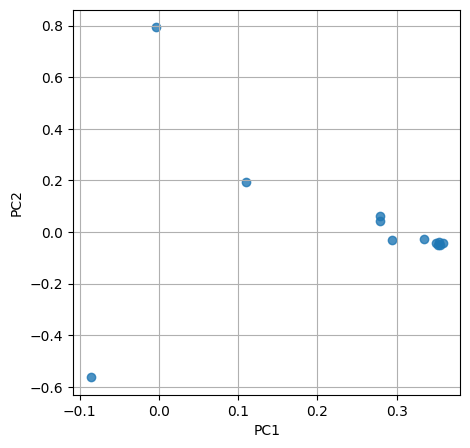

In [19]:
plt.figure(figsize=(5, 5))
# for x, y, name in zip(pca.components_[0], pca.components_[1], df.columns[1:]):
#     plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()